# 2. Generate 5 Images Using Noise (𝑁(5, 1)) Through the Decoder of a Denoising Autoencoder (CIFAR-10)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)


In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


In [15]:
# Data Summary
print(f"Samples: {len(train_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Classes: {train_dataset.classes}")

Samples: 50000
Image shape: torch.Size([3, 32, 32])
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


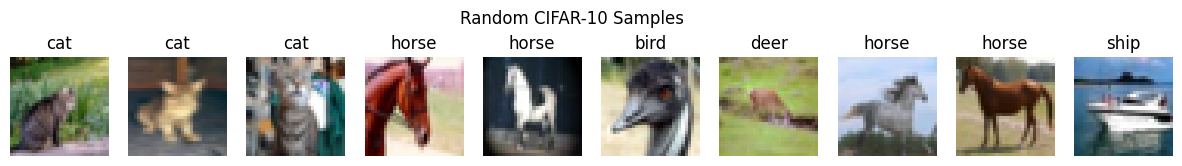

In [16]:
# Visualize 10 random samples
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]
    img = img * 0.5 + 0.5  # Denormalize
    axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[i].set_title(train_dataset.classes[label])
    axes[i].axis('off')
plt.suptitle("Random CIFAR-10 Samples")
plt.show()

Denoising autoencoder

In [17]:
latent_dim = 128

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 8 * 8),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),   # 16x16 -> 32x32
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [ ]:
model = DenoisingAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 10

for epoch in range(epochs):
    model.train()
    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        # Add Gaussian noise
        noise = torch.randn_like(imgs) * 0.2
        noisy_imgs = imgs + noise
        noisy_imgs = torch.clamp(noisy_imgs, -1.0, 1.0)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.0215
Epoch [2/10], Loss: 0.0257
Epoch [3/10], Loss: 0.0215
Epoch [4/10], Loss: 0.0214
Epoch [5/10], Loss: 0.0193
Epoch [6/10], Loss: 0.0212
Epoch [7/10], Loss: 0.0209
Epoch [8/10], Loss: 0.0207
Epoch [9/10], Loss: 0.0184
Epoch [10/10], Loss: 0.0195


In [19]:
model.eval()
with torch.no_grad():
    noise_latents = torch.randn(5, latent_dim) + 5
    generated = model.decoder(noise_latents.to(device)).cpu()

# Denormalize from [-1, 1] → [0, 1]
generated = (generated + 1) / 2.0
generated = torch.clamp(generated, 0, 1)


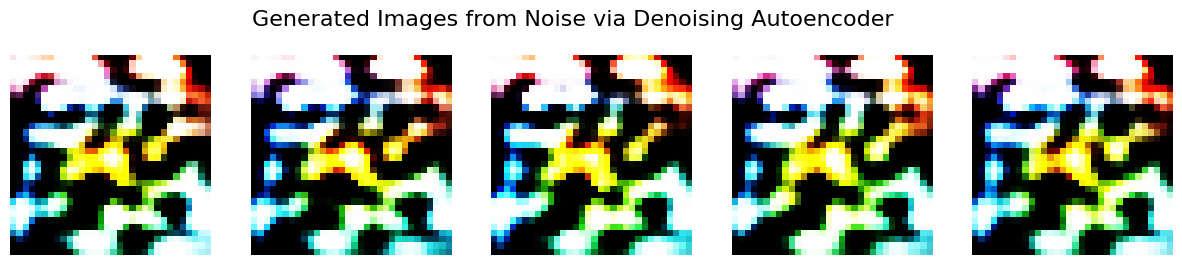

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = generated[i].numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')
plt.suptitle("Generated Images from Noise via Denoising Autoencoder", fontsize=16)
plt.show()
